In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from pygenomeviz import GenomeViz
import seaborn as sns
import requests
import json
import logging
import numpy as np

In [138]:
def get_transcripts_names(gene: str, info_transcripts = 'n', return_transcript = 'only canonical'):
    server = "https://rest.ensembl.org"
    search_canonical = "/lookup/symbol/homo_sapiens/" + gene + "?expand=1"

    r = requests.get(server+search_canonical, headers={ "Content-Type" : "application/json"})
    res = json.loads(r.content)
    
    try:
        canonical = res['canonical_transcript'].split('.')[0]
    except:
        canonical = res['canonical_transcript']

    non_canonical = []
    
    for i in range(len(res['Transcript'])):
        if res['Transcript'][i]['id']!=canonical:
            non_canonical.append((res['Transcript'][i]['id'], len(res['Transcript'][i]['Exon'])))
    
    if info_transcripts == 'y':
        additional_info = f'Canonical transcript (from NCBI database) for {gene} is {canonical}, however where are few other transcripts - {non_canonical}.\n \nThe number is the number of exons\n \nIf you want to get information about particular transcript, please, specify the "transcript_name" in the SHOW_EXON_STRUCTURE function. \nThe "transcript_name" should be a string'
        print (additional_info)
    
    if return_transcript == 'only canonical':
        return canonical
    else:
        return (canonical, non_canonical)

In [122]:
def get_gene_info(gene: str, transcript = 'canonical'):
    
    server = "https://rest.ensembl.org"
    if transcript == 'canonical':
        transcript_ = get_transcripts_names(gene)
        search_for_exons = "/lookup/id/" + transcript_+ "?expand=1"
    else:
        search_for_exons = "/lookup/id/" + transcript+ "?expand=1"
        
    r = requests.get(server+search_for_exons, headers={ "Content-Type" : "application/json"})
    res = json.loads(r.content)
    
    final = pd.DataFrame(res['Exon'])
    
    return final

In [254]:
def show_exon_structure(gene: str, 
                        give_df = 'n',
                        save_fig = 'n', 
                        transcript_name = 'canonical'):
    '''
    This function return you the picture of exons for different gene transcripts. By default, it is the canonical transcript
        from NCBI database. If you want to get additional info about other transcripts call the "get_transcripts_names" function
        with "info_transcripts = 'y'"" param and choose one.
    If you know the particular transcript name, please, specify "transcript_name" param by giving a string of the transcript name
    '''
    
    df= get_gene_info(gene, transcript = transcript_name)
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
    
    df['len'] = df['end']-df['start']
    
    
    df.loc[0,'new_start'] = 0
    df.loc[0, 'new_end'] = df.loc[0, 'len']

    step = 50

    for i in range (1,len(df)):
        df.loc[i, 'new_start'] = step + df.loc[i-1, 'new_end']
        df.loc[i, 'new_end'] = df.loc[i, 'new_start'] + df.loc[i, 'len']
        
    exon_list=[]

    for i in range (len(df)):
        exon_start = df.loc[i, 'new_start']
        exon_end = df.loc[i, 'new_end']
        exon = (exon_start, exon_end)

        exon_list.append(exon)

    gv = GenomeViz()
    
    if df.loc[0, 'strand'] ==1:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))]
        df['exon_n'] = [i+1 for i in range(len(exon_list))]
    else:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))][::-1]
        df['exon_n'] = [i+1 for i in range(len(exon_list))][::-1]
        
    track = gv.add_feature_track(name=f"{gene} exons \n{transcript_name}",
                                 size=df.loc[len(df)-1, 'new_end']+100,
                                 labelsize=15,
                                 linewidth=0)
    
    track.add_exon_feature(exon_list,
                           strand=df.loc[0, 'strand'],
                           facecolor="lightcyan",
                           linewidth=1,
                           labelrotation=0,
                           labelha="center",
                           exon_labels=exon_labels,
                           exon_label_kws={"y": 0, "va": "center", "color": "blue", 'fontsize': 10},
                           size_ratio = 1)
    
    if save_fig == 'y':
        gv.savefig(f"{gene}_first.png")
    
    if give_df == 'y':
        return df
    else:
        return gv.plotfig()

In [236]:
transcript = get_transcripts_names('RET', info_transcripts = 'y')

Canonical transcript (from NCBI database) for RET is ENST00000355710, however where are few other transcripts - [('ENST00000671844', 16), ('ENST00000672389', 14), ('ENST00000340058', 19), ('ENST00000498820', 5), ('ENST00000615310', 17), ('ENST00000638465', 2), ('ENST00000640619', 2), ('ENST00000683278', 2), ('ENST00000684216', 2), ('ENST00000683007', 16), ('ENST00000683872', 9)].
 
The number is the number of exons
 
If you want to get information about particular transcript, please, specify the "transcript_name" in the SHOW_EXON_STRUCTURE function. 
The "transcript_name" should be a string


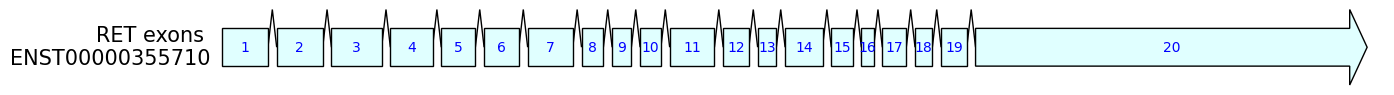

In [255]:
fig = show_exon_structure('RET')

In [163]:
show_exon_structure('MAX', give_df = 'y')

,seq_region_name,end,start,id,assembly_name,strand,object_type,species,db_type,version,len,new_start,new_end,exon_n
0,14,65102517,65102304,ENSE00003500404,GRCh38,-1,Exon,homo_sapiens,core,1,213,0.0,213.0,5
1,14,65101572,65101546,ENSE00003470068,GRCh38,-1,Exon,homo_sapiens,core,1,26,263.0,289.0,4
2,14,65093815,65093708,ENSE00003507137,GRCh38,-1,Exon,homo_sapiens,core,1,107,339.0,446.0,3
3,14,65078036,65077913,ENSE00003459724,GRCh38,-1,Exon,homo_sapiens,core,1,123,496.0,619.0,2
4,14,65076663,65075127,ENSE00001884996,GRCh38,-1,Exon,homo_sapiens,core,2,1536,669.0,2205.0,1


# Определяем положение мутаций в новой системе координат

In [219]:
def show_exon_and_mutations (gene: str,
                             df_mut,
                        give_df = 'n',
                        save_fig = 'n', 
                        transcript_name = 'canonical'):
    '''
    This function return you the picture of exons and given mutations for different gene transcripts. By default, it is the canonical transcript
        from NCBI database. If you want to get additional info about other transcripts call the "get_transcripts_names" function
        with "info_transcripts = 'y'"" param and choose one.
    If you know the particular transcript name, please, specify "transcript_name" param by giving a string of the transcript name
    '''
    
    df= get_gene_info(gene, transcript = transcript_name)
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
    
    df['len'] = df['end']-df['start']
    
    
    df.loc[0,'new_start'] = 0
    df.loc[0, 'new_end'] = df.loc[0, 'len']

    step = 50

    for i in range (1,len(df)):
        df.loc[i, 'new_start'] = step + df.loc[i-1, 'new_end']
        df.loc[i, 'new_end'] = df.loc[i, 'new_start'] + df.loc[i, 'len']
        
    exon_list=[]

    for i in range (len(df)):
        exon_start = df.loc[i, 'new_start']
        exon_end = df.loc[i, 'new_end']
        exon = (exon_start, exon_end)

        exon_list.append(exon)

    gv = GenomeViz()
    
    if df.loc[0, 'strand'] ==1:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))]
        df['exon_n'] = [i+1 for i in range(len(exon_list))]
    else:
        exon_labels = [f"{i+1}" for i in range(len(exon_list))][::-1]
        df['exon_n'] = [i+1 for i in range(len(exon_list))][::-1]
        
    df_mut['n']=''

    for i in range(len(df_mut)):
        for j in range(len(df)):
            if df.loc[j, 'start']<df_mut.loc[i, 'pos']<df.loc[j, 'end']:
                df_mut.loc[i,'n'] = j+1
                
    df_mut['pos_new'] = ''
    
    for i in range(len(df_mut)):
        if df_mut.loc[i, 'n'] != '':
            df_mut.loc[i,'pos_new'] = df.loc[df_mut.loc[i, 'n']-1, 'new_end'] - (df.loc[df_mut.loc[i, 'n']-1, 'end']-df_mut.loc[i, 'pos'])           

        
    track = gv.add_feature_track(name=f"{gene} exons \n{transcript_name}",
                                 size=df.loc[len(df)-1, 'new_end']+100,
                                 labelsize=15,
                                 linewidth=0)
    
    track.add_exon_feature(exon_list,
                           strand=df.loc[0, 'strand'],
                           facecolor="lightcyan",
                           linewidth=1,
                           labelrotation=0,
                           labelha="center",
                           exon_labels=exon_labels,
                           exon_label_kws={"y": 0, "va": "center", "color": "blue", 'fontsize': 10},
                           size_ratio = 1)
    
    for i in range(len(df_mut)):
        if df_mut.loc[i, 'n'] != '':
            track.add_feature(start=df_mut.loc[i,'pos_new']-5, end=df_mut.loc[i,'pos_new']+5, plotstyle="box", label=f"{df_mut.loc[i,'pos']}", labelrotation=90, labelsize=10, facecolor="black", labelha='center', size_ratio = 1)

    
    if save_fig == 'y':
        gv.savefig(f"{gene}_first.png")
    
    if give_df == 'y':
        return df
    else:
        return gv.plotfig()

In [232]:
df_ret = pd.DataFrame([[43104974],
[43105029],
[43105119],
[43105176],
[43105191],
[43106428],
[43106433]])

In [233]:
df_ret = df_ret.rename(columns={0:'pos'})


In [234]:
df_ret

,pos
0,43104974
1,43105029
2,43105119
3,43105176
4,43105191
5,43106428
6,43106433


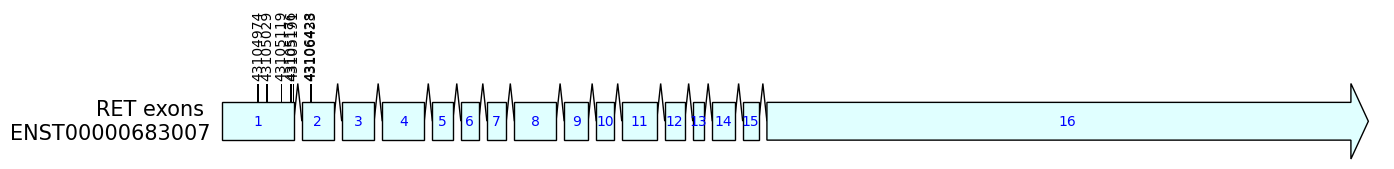

In [238]:
fig = show_exon_and_mutations (gene='RET', transcript_name = 'ENST00000683007', df_mut = df_ret)

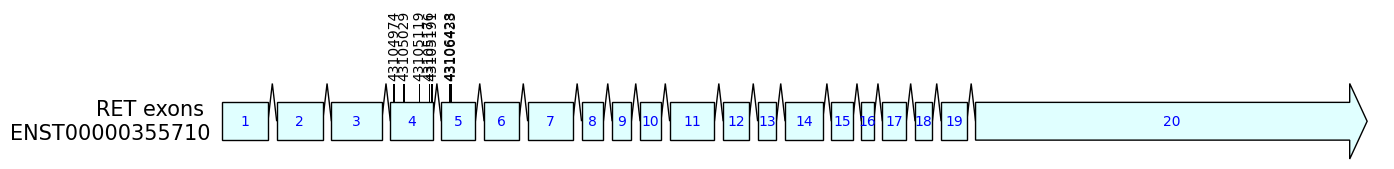

In [239]:
fig = show_exon_and_mutations (gene='RET', df_mut = df_ret)

In [334]:
def get_protein_info(gene: str,
                     to_return = 'filtered',
                     transcript_name = 'canonical'): #to_return = 'final' or 'all'
    
    if transcript_name == 'canonical':
        transcript_name = get_transcripts_names(gene)
        
        
    server_uni = "https://rest.uniprot.org"
    search_uniprot = "/uniprotkb/search?query="+transcript_name+"&format=json"
    
    try:
        r = requests.get(server_uni+search_uniprot, headers={ "Content-Type" : "application/json"})
        res = json.loads(r.content)
        #protein_id = res['results'][0]['primaryAccession']
        
    except:
        return('No information about protein in UniProtKB')
    
    df = pd.DataFrame()
    #df.columns = ['type', 'start', 'end', 'description']
    for i in range(len(res['results'][0]['features'])):
        df.loc[i, 'type'] = res['results'][0]['features'][i]['type']
        df.loc[i, 'start'] = res['results'][0]['features'][i]['location']['start']['value']
        df.loc[i, 'end'] = res['results'][0]['features'][i]['location']['end']['value']
        df.loc[i, 'description'] = res['results'][0]['features'][i]['description']
    
    for i in range (len(df)):
        if df.loc[i, 'type']=='Transmembrane':
            df.loc[i, 'description']=='Transmembrane'
    
    f = (df['type']=='Transmembrane') | (df['type']=='Domain') | (df['type']=='Repeat') | (df['type']=='Intramembrane')
    final=df[f]
    
    if to_return == 'filtered':
        return final
    else:
        return df